# Profile Evaluation Notebook

## Set Directory

In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

## Import

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from ast import literal_eval
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.stats.stats import pearsonr   
from sklearn.decomposition import PCA

import utils

## Configs

In [3]:
EXPERIMENTS = ['HRCE-1', 'HRCE-2']
PLATE_NUMBERS = {
    'HRCE-1': 26,
    'HRCE-2': 27
}

pd.set_option('display.max_columns', 10)
sns.set(rc={'figure.figsize':(10,7)})

## Data Paths

In [4]:
DATA_PATH = '../data'

FEATURES_PATH = os.path.join('..', 'features')

METADATA_PATH = os.path.join(DATA_PATH, 'metadata.csv')
EMBEDDING_FEATURES_PATH = os.path.join(DATA_PATH, 'embeddings', 'embeddings.csv')
MOA_PATH = os.path.join(DATA_PATH, 'MOA.csv')

CP_NORMAL_FILE = 'normalized_well_profile.csv'

## Load Profiles

In [5]:
def load_profiles(experiments, plate_numbers, profile_name, drop_cols=[]):
    profiles = []
    for experiment in experiments:
        for i in tqdm(range(1, plate_numbers[experiment]+1)):
            data_path = os.path.join(
                FEATURES_PATH, experiment, 'Plate'+str(i), profile_name)
            profile = pd.read_csv(data_path)
            if 'well_id' not in profile.columns: print(i)
            profiles.append(profile)
    profiles = (
        pd.concat(profiles, axis=0, join='inner').drop(drop_cols, axis=1)
    ).dropna(axis=1)
    granularity_columns = [x for x in profiles.columns if ('Granularity' in x)]
    profiles = profiles.drop(granularity_columns, axis=1)
    return profiles

In [6]:
profiles = load_profiles(EXPERIMENTS, PLATE_NUMBERS, CP_NORMAL_FILE, drop_cols=['label', 'groupid'])
profiles.shape

100%|███████████████████████████████████████████| 27/27 [00:20<00:00,  1.33it/s]


(71013, 2329)

## Load Embeddings

In [7]:
def aggregate_site_to_well_level(dataframe):
    dataframe.site_id = dataframe.site_id.apply(lambda x: x[:-2])
    dataframe = (
        dataframe
        .rename({'site_id': 'well_id'}, axis=1)
        .groupby('well_id')
        .mean()
        .reset_index()
    )
    return dataframe

site_embeddings = pd.read_csv(EMBEDDING_FEATURES_PATH)
rxrx19a_profiles = aggregate_site_to_well_level(site_embeddings)
np.shape(rxrx19a_profiles)

(76380, 1025)

## Load Metadatas

In [8]:
def load_metadata(metadata_path, experiments):
    def label(disease_condition):
        if  disease_condition == 0: return 'negctrl'
        else: return 'posctrl'
    metadata = pd.read_csv(metadata_path)    
    metadata = metadata[metadata.experiment.isin(experiments)]
    metadata.treatment = metadata.treatment.str.lower()
    metadata = metadata[['treatment', 'treatment_conc' , 'well_id', 'disease_condition', 'experiment']]
    metadata = metadata.fillna(0)
    metadata['label'] = metadata.apply(lambda row: label(row.disease_condition), axis=1)
    metadata = metadata.assign(
        groupid = metadata.groupby(
            ['treatment', 'treatment_conc', 'disease_condition']).ngroup())
    metadata = metadata.assign(
        treatmentid = metadata.groupby(
            ['treatment', 'disease_condition']).ngroup())
    return metadata

In [9]:
metadata = load_metadata(METADATA_PATH, EXPERIMENTS).set_index('well_id')

## Experiment Info

In [10]:
def get_group_info(data):
    return (
        data.reset_index().drop_duplicates()
        [['label', 'groupid']]
        .groupby('groupid').count()
        .reset_index()
        .groupby('label')
        .count()
        .rename_axis('group_size')
        .rename({'groupid' : 'count'}, axis=1)
    )

print('Profile treatment-condition groups information:')
get_group_info(metadata)

Profile treatment-condition groups information:


,count
group_size,
6,9452
11,232
12,203
1606,1
2120,2
3474,1


## Add Metadata to Profiles

In [11]:
def add_metadata_to_profiles(metadata, profiles):
    return (
        metadata.join(profiles.set_index('well_id'), how='inner')
        .drop_duplicates()
    )

In [12]:
profiles_with_meta = add_metadata_to_profiles(metadata, profiles)
profiles_with_meta.shape

(71013, 2335)

In [13]:
rxrx19a_profiles_with_meta = add_metadata_to_profiles(metadata, rxrx19a_profiles)
rxrx19a_profiles_with_meta.shape

(71020, 1031)

In [14]:
ctrls = (
    profiles_with_meta[profiles_with_meta.label == 'negctrl']
    .drop(metadata.columns, axis=1)
)

active_sars = (
    profiles_with_meta[
        (profiles_with_meta.disease_condition == 'Active SARS-CoV-2') &
        (profiles_with_meta.treatment == 0)
    ]
).drop(metadata.columns, axis=1)

mocks  = (
    profiles_with_meta[profiles_with_meta.disease_condition == 'Mock']
    .drop(metadata.columns, axis=1)
)

UV_inactive_sars = (
    profiles_with_meta[
    profiles_with_meta.disease_condition == 'UV Inactivated SARS-CoV-2']
    .drop(metadata.columns, axis=1)
)

treatments = (
    profiles_with_meta[profiles_with_meta.treatment != 0]
    .drop(metadata.columns, axis=1)
)

treatments.shape, active_sars.shape, mocks.shape, UV_inactive_sars.shape, ctrls.shape

((61693, 2328), (3474, 2328), (2120, 2328), (2120, 2328), (1606, 2328))

## On score algorithm accuracy check (test)

In [82]:
test_rxrx19a.disease_condition.unique()

array(['Active SARS-CoV-2', 'UV Inactivated SARS-CoV-2', 0, 'Mock'],
      dtype=object)

In [83]:
test_rxrx19a = rxrx19a_profiles_with_meta[rxrx19a_profiles_with_meta.experiment == 'HRCE-1']


zero_center = (
    test_rxrx19a[test_rxrx19a.disease_condition.isin(['Mock'])]
    .drop(metadata.columns, axis=1)
).mean()
one_center = (
    test_rxrx19a[test_rxrx19a.disease_condition == 'Active SARS-CoV-2']
    .drop(metadata.columns, axis=1)
).mean()

In [84]:
cpe_scores = rxrx19a_profiles.set_index('well_id').apply(
    lambda row: 
    pd.Series({
        'on_score':utils.calculate_on_score(row.values, zero_center, one_center), 
        'off_score':utils.calculate_off_score(row.values, zero_center, one_center)
    }), axis=1)

In [85]:
scores = (
    cpe_scores.join(metadata, how='inner')
    .groupby(['treatment', 'treatment_conc', 'experiment']).mean()
    .reset_index()
    [['treatment', 'treatment_conc', 'experiment', 'on_score', 'off_score']]
    .drop_duplicates()
)
scores

,treatment,treatment_conc,experiment,on_score,off_score
0,0,0.00,HRCE-1,2.974453,5.912907
1,0,0.00,HRCE-2,4.080826,10.216976
2,(+)-cedrol,0.01,HRCE-2,6.543715,10.481033
3,(+)-cedrol,0.03,HRCE-2,6.533395,10.216535
4,(+)-cedrol,0.10,HRCE-2,5.728633,9.643804
...,...,...,...,...,...
10211,β-estradiol 17-acetate,0.03,HRCE-1,7.017563,5.742163
10212,β-estradiol 17-acetate,0.10,HRCE-1,7.904773,5.837033
10213,β-estradiol 17-acetate,0.30,HRCE-1,7.385185,5.580851
10214,β-estradiol 17-acetate,1.00,HRCE-1,7.970960,5.346158


In [86]:
def refine_exp(x):
    if x == 'COVID19-launchedp1-HRCE-X-b-20x': return 'HRCE-1'
    else: return 'HRCE-2'

RXRX19_SCORES_PATH = os.path.join(DATA_PATH, 'supplementary', 'media-2.csv')
rxrx19a_scores = pd.read_csv(RXRX19_SCORES_PATH)
rxrx19a_scores.treatment = rxrx19a_scores.treatment.str.lower()
rxrx19a_scores = rxrx19a_scores[rxrx19a_scores.experiment.isin(
    ['COVID19-launchedp2-HRCE-X-b-20x', 'COVID19-launchedp1-HRCE-X-b-20x'])]
rxrx19a_scores['experiment'] = rxrx19a_scores.apply(lambda row: refine_exp(row['experiment']), axis=1)
rxrx19a_scores = rxrx19a_scores.drop_duplicates()
rxrx19a_scores = rxrx19a_scores#[rxrx19a_scores.experiment == 'HRCE-2']

In [87]:
joined_scores = (
    scores.merge(rxrx19a_scores,
        on=['treatment', 'treatment_conc', 'experiment'],
        how='inner'
    )
)
joined_scores.shape

(10318, 7)

In [88]:
from scipy import stats
stats.spearmanr(joined_scores.on_disease_score, joined_scores.on_score)

SpearmanrResult(correlation=0.6583239637176618, pvalue=0.0)

In [89]:
stats.spearmanr(joined_scores.off_disease_score, joined_scores.off_score)

SpearmanrResult(correlation=0.8061937856648246, pvalue=0.0)

## Whitening PCA

In [15]:
pca = PCA(n_components=1024, whiten=True).fit(ctrls)

In [16]:
tvn_treatments = pd.DataFrame(pca.transform(treatments), index=treatments.index)
tvn_actives = pd.DataFrame(pca.transform(active_sars), index=active_sars.index)
tvn_mocks = pd.DataFrame(pca.transform(mocks), index=mocks.index)
tvn_uvs = pd.DataFrame(pca.transform(UV_inactive_sars), index=UV_inactive_sars.index)
tvn_ctrls = pd.DataFrame(pca.transform(ctrls), index=ctrls.index)

tvn_features = pd.concat(
    [tvn_treatments, tvn_actives, tvn_mocks, tvn_uvs, tvn_ctrls], axis=0
)
tvn_features.shape

(71013, 1024)

In [17]:
tvn_features.to_csv('~/data/tvn_well_all_hrce.csv')

<AxesSubplot:>

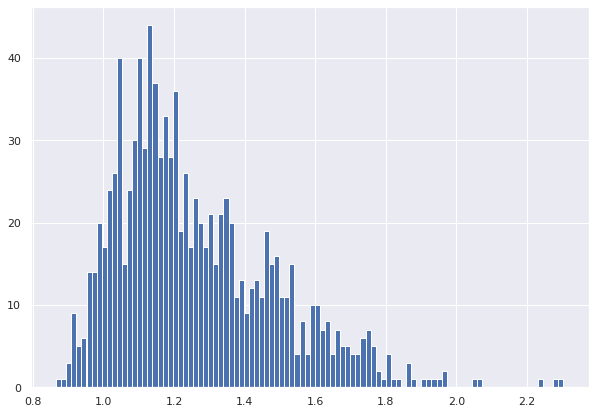

In [26]:
tvn_mocks.std().hist(bins=100)

## Replicate Reproducibility Test

In [31]:
BACKGROUND_DIST_GROUP_SIZE = 6
BACKGROUND_DIST_NUM_SAMPLES = 10000
THRESHOLD = 0.95

In [74]:
def similarity(table):
    sigma = table.T.corr(method='pearson')
    return sigma


def random_sample(profile, metadata, sample_size):
    group_ids = metadata.groupid.unique()
    sub_sample_ids = random.sample(list(group_ids), min(len(group_ids),sample_size))
    imagnumbers = []
    for sample_id in sub_sample_ids:
        row = metadata[metadata.groupid == sample_id].sample()
        imagnumbers.append(row.index.tolist()[0])
    sample = profile.loc[imagnumbers]
    return sample


def background_distribution(profile, metadata, group_size, num_samples):
    background_dist = []
    for i in range(num_samples):
        sample = random_sample(profile, metadata, group_size)
        sigma = similarity(sample)
        up_tri = np.asarray(sigma)[np.triu_indices(sigma.shape[0], k=1)]
        mcc = up_tri.mean()
        background_dist.append(mcc)
    return background_dist

def find_threshold(distribution, coef):
    confidence_interval = pd.Series(sorted(distribution)).quantile([coef])
    return float(confidence_interval)


def test_expriment(profile, metadata):
    result = []
    bed_groups = []
    group_ids = list(metadata.groupid.unique())
    for group_id  in group_ids:
        test_group = profile.loc[list(metadata[metadata.groupid == group_id].index)]
        if len(test_group) < 2: 
            print('Group {} has less than 2 samples.'.format(group_id))
            bed_groups.append(group_id)
            continue
        sigma = similarity(test_group)
        up_tri = np.asarray(sigma)[np.triu_indices(sigma.shape[0], k=1)]
        mcc = up_tri.mean()
        result.append(mcc)
    return result, bed_groups


def plot_hist(bgdist, exp, threshold_val):
    sns.set(rc={'figure.figsize':(7, 5)})
    ax = plt.gca()
    ax.set_facecolor('white')
    plt.xlabel('Correlation') 
    plt.ylabel('Frequency') 
    kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=100, ec="k")
    plt.hist(bgdist, **kwargs, label='Null')
    plt.hist(exp, **kwargs, label='Experiment')
    plt.axvline(threshold_val, color='red', linewidth=0.5, linestyle='-')
    plt.grid(True, color='gray', linestyle="-.", linewidth=0.5)
    plt.legend(loc="upper left")
    plt.show()


def replicate_reproducibility(features, labels, name, normalize=False): 
    print('Calculating Back Ground Distribution ...')

    bgdist = background_distribution(
        features, 
        labels, 
        group_size=BACKGROUND_DIST_GROUP_SIZE, 
        num_samples=BACKGROUND_DIST_NUM_SAMPLES)
    
    threshold_val = find_threshold(bgdist, THRESHOLD)
    
    print('Calculating Experiment Distribution ...')
    exp, bed_groups = test_expriment(features, labels)
    group_ids = list(labels[~labels.groupid.isin(bed_groups)].groupid.unique())

    result_pdf = pd.DataFrame([])
    result_pdf['replicate_corr'.format(name)] = exp
    result_pdf['groupid'] = group_ids
    result_pdf['above_threshold'.format(name)] = [i > threshold_val for i in exp]
    result_pdf['threshold'.format(name)] = threshold_val

    
    bad_groupids = []
    for gid, exp_mcc in zip(group_ids, exp):
        if exp_mcc < threshold_val:
            bad_groupids.append(gid)
    above_threshold_percent = (1 - len(bad_groupids)/len(group_ids))*100
    print('{:.2f} percent of groups are above threshold.'.format(
        above_threshold_percent))
    
    plot_hist(bgdist, exp, threshold_val)
    return result_pdf, bgdist, exp, threshold_val

Calculating Back Ground Distribution ...
Calculating Experiment Distribution ...
98.95 percent of groups are above threshold.


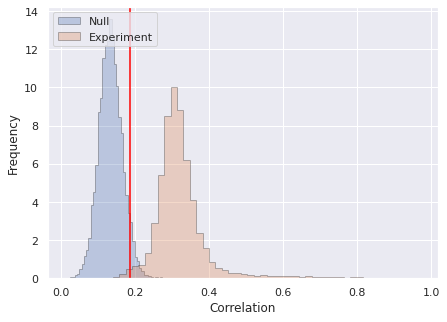

In [53]:
replicate_corr, bgdist, exp, threshold_val = replicate_reproducibility(
    tvn_treatments, 
    tvn_treatments.join(metadata), 
    'tvn')

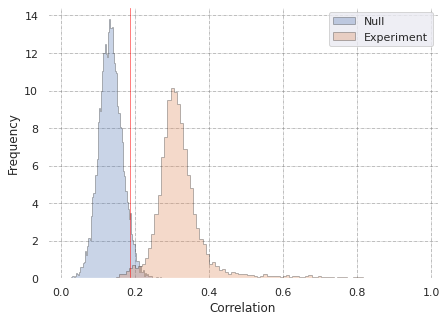

In [73]:
# def plot_hist(bgdist, exp, threshold_val):
sns.set(rc={'figure.figsize':(7, 5)})
ax = plt.gca()
ax.set_facecolor('white')
plt.xlabel('Correlation') 
plt.ylabel('Frequency') 
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=100, ec="k")
plt.hist(bgdist, **kwargs, label='Null')
plt.hist(exp, **kwargs, label='Experiment')
plt.axvline(threshold_val, color='red', linewidth=0.5, linestyle='-')
plt.grid(True, color='gray', linestyle="-.", linewidth=0.5)
plt.legend(loc="upper right")
plt.show()
# plot_hist(bgdist, exp, threshold_val)

Calculating Back Ground Distribution ...
Calculating Experiment Distribution ...
38.26 percent of groups are above threshold.


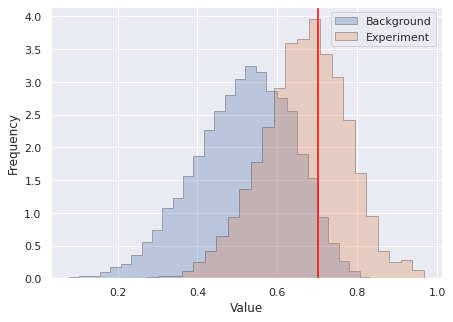

In [34]:
normal_replicate_corr = replicate_reproducibility(
    treatments, 
    treatments.join(metadata), 
    'normal')

Calculating Back Ground Distribution ...
Calculating Experiment Distribution ...
80.85 percent of groups are above threshold.


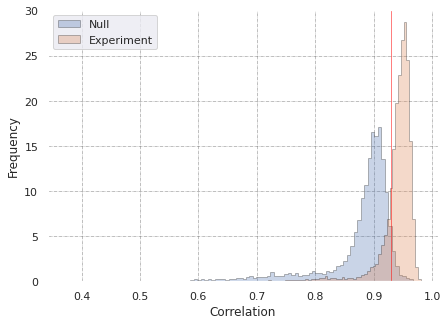

In [75]:
rxrx19a_replicate_corr = replicate_reproducibility(
    rxrx19a_profiles.set_index('well_id'), 
    rxrx19a_profiles_with_meta[rxrx19a_profiles_with_meta.treatment != 0], 
    'rxrx19a')

## MOA Enrichment 

### Treatment to MOA

In [22]:
moa_embl = pd.read_csv('../data/rxrx19_moa.csv', index_col=0)
moa_embl = moa_embl[['treatment', 'Mechanism of Action']]
moa_embl = moa_embl[moa_embl['Mechanism of Action'] != 'Unknown']
moa_embl = (
    pd.DataFrame(moa_embl['Mechanism of Action']
                 .str.split(';')
                 .tolist(), index=moa_embl['treatment'])
    .stack().reset_index()
)
moa_embl.columns = ['treatment', 'level_1', 'moa']
moa_embl = moa_embl[['treatment', 'moa']]
moa_embl.head()

,treatment,moa
0,l-glutamic acid,Nutritional support
1,glucosamine,Supplement
2,picosulfate,Stimulant laxative
3,lactulose,Colonic bacteria substrate
4,thiamine,Supplement


In [23]:
moa_repurposing = pd.read_csv(MOA_PATH)
moa_repurposing.moa = moa_repurposing.moa.apply(literal_eval)
moa_repurposing = moa_repurposing.explode('moa')
moa_repurposing.head()

,treatment,moa
0,(+)-cedrol,sedative
1,(+)-cloprostenol,prostaglandin receptor agonist
2,(+)-ephedrine (hydrochloride),adrenergic receptor agonist
3,(-)-huperzine a (hupa),acetylcholinesterase inhibitor
4,(r)-baclofen,benzodiazepine receptor agonist


In [24]:
moa = pd.concat([moa_repurposing, moa_embl], join='inner')
moa.moa = moa.moa.str.lower()
moa = moa.groupby('treatment')['moa'].apply(set).reset_index()
moa

,treatment,moa
0,(+)-cedrol,{sedative}
1,(+)-cloprostenol,{prostaglandin receptor agonist}
2,(+)-ephedrine (hydrochloride),{adrenergic receptor agonist}
3,(-)-huperzine a (hupa),{acetylcholinesterase inhibitor}
4,(r)-baclofen,"{benzodiazepine receptor agonist, gaba-b recep..."
...,...,...
1627,zonisamide,"{sodium channel blocker, t-type calcium channe..."
1628,zotarolimus,"{fk506-binding protein 1a inhibitor, mtor inhi..."
1629,zotepine,"{dopamine receptor antagonist, serotonin recep..."
1630,zuclopenthixol,{dopamine receptor antagonist}


In [25]:
treatment_to_moa = moa.set_index('treatment').moa.to_dict()

In [26]:
missing_treatments = set(metadata.treatment.unique()) - set(treatment_to_moa.keys())
for missing_treatment in missing_treatments:
    treatment_to_moa[missing_treatment] = {}

### Correlation

In [27]:
def calculate_correlation(features, metadata):
    with_meta = (
        features
        .join(metadata)
        .groupby(['treatment', 'treatment_conc']).mean()
        .reset_index()
    )
    with_meta = with_meta[with_meta.treatment != 0]
    return(
        with_meta
        .set_index('treatment')
        .drop(['treatment_conc', 'groupid', 'treatmentid'], axis=1)
    ).T.corr(method='pearson')

In [177]:
correlation = calculate_correlation(tvn_treatments, metadata)
correlation.shape

(9887, 9887)

In [32]:
significant_replicates = normal_replicate_corr[normal_replicate_corr.above_threshold].groupid.to_frame('groupid')

In [38]:
significant_profiles = (
    treatments.join(metadata).reset_index()
    .merge(significant_replicates, on='groupid')
    .set_index('well_id').drop(metadata.columns, axis=1)
)

In [39]:
normal_correlation = calculate_correlation(significant_profiles, metadata)
normal_correlation.shape

(5244, 5244)

In [178]:
rxrx19a_correlation = calculate_correlation(
    rxrx19a_profiles.set_index('well_id'), metadata)
rxrx19a_correlation.shape

(9887, 9887)

In [41]:
def sort_pairwise_correlation(correlation, ascending=False):
    keep = np.triu(np.ones(correlation.shape)).astype('bool').reshape(correlation.size)
    pairwise_correlations = correlation.stack(dropna=True, level=0)[keep].to_frame()
    pairwise_correlations = pairwise_correlations.reset_index(level=0)
    pairwise_correlations.columns = ['treatment2', 'correlation']
    pairwise_correlations = pairwise_correlations.reset_index()
    pairwise_correlations = pairwise_correlations[
        pairwise_correlations.treatment != pairwise_correlations.treatment2
    ]
    pairwise_correlations = pairwise_correlations.groupby(['treatment', 'treatment2']).max()
    pairwise_correlations = pairwise_correlations.sort_values('correlation', ascending=ascending)
    return pairwise_correlations

def divide_dataframe(dataframe, ratio):
    max_index = int(len(dataframe) * ratio)
    top_dataframe = dataframe.iloc[:max_index]
    down_dataframe = dataframe.iloc[max_index+1:]
    return top_dataframe, down_dataframe

In [180]:
sorted_correlation = sort_pairwise_correlation(correlation)

high_correlated, correlated = divide_dataframe(
    sorted_correlation, ratio=0.05)

len(high_correlated), len(correlated)

(66953, 1272112)

In [42]:
normal_sorted_correlation = sort_pairwise_correlation(normal_correlation)

normal_high_correlated, normal_correlated = divide_dataframe(
    normal_sorted_correlation, ratio=0.05)

len(normal_high_correlated), len(normal_correlated)

(62212, 1182040)

In [182]:
rxrx19a_sorted_correlation = sort_pairwise_correlation(rxrx19a_correlation)

rxrx19a_high_correlated, rxrx19a_correlated = divide_dataframe(
    rxrx19a_sorted_correlation, ratio=0.05)

len(rxrx19a_high_correlated), len(rxrx19a_correlated)

(66953, 1272112)

In [43]:
def calculate_treatment_similarity(dataframe):

    similarity = dataframe.apply(
        lambda row: utils.moa_similarity(
            treatment_to_moa[row.name[0]],
            treatment_to_moa[row.name[1]]
        ),
        axis=1
    )
    return similarity.tolist()

In [184]:
high_correlated_profile_similarity = calculate_treatment_similarity(high_correlated)
correlated_profile_similarity = calculate_treatment_similarity(correlated)
np.shape(high_correlated_profile_similarity), np.shape(correlated_profile_similarity)

((66953,), (1272112,))

In [185]:
profile_contingency_table = utils.create_contingency_table(
    high_correlated_profile_similarity, correlated_profile_similarity)
print(profile_contingency_table)

oddsratio, pvalue = stats.fisher_exact(profile_contingency_table) 

print('odds ratio for Profile = {}'.format(oddsratio))
print('pvalue for Profile = {}'.format(pvalue))

[[1150, 65803], [18686, 1253426]]
odds ratio for Profile = 1.1722884904907434
pvalue for Profile = 3.905937010748695e-07


In [44]:
high_correlated_normal_profile_similarity = calculate_treatment_similarity(normal_high_correlated)
correlated_normal_profile_similarity = calculate_treatment_similarity(normal_correlated)
np.shape(high_correlated_normal_profile_similarity), np.shape(correlated_normal_profile_similarity)

((62212,), (1182040,))

In [45]:
profile_contingency_table = utils.create_contingency_table(
    high_correlated_normal_profile_similarity, correlated_normal_profile_similarity)
print(profile_contingency_table)

oddsratio, pvalue = stats.fisher_exact(profile_contingency_table) 

print('odds ratio for Profile = {}'.format(oddsratio))
print('pvalue for Profile = {}'.format(pvalue))

[[1064, 61148], [17283, 1164757]]
odds ratio for Profile = 1.1726693394904562
pvalue for Profile = 9.622113353427936e-07


In [186]:
rxrx19a_high_correlated_profile_similarity = calculate_treatment_similarity(
    rxrx19a_high_correlated)
rxrx19a_correlated_profile_similarity = calculate_treatment_similarity(
    rxrx19a_correlated)
np.shape(rxrx19a_high_correlated_profile_similarity), np.shape(rxrx19a_correlated_profile_similarity)

((66953,), (1272112,))

In [187]:
profile_contingency_table = utils.create_contingency_table(
    rxrx19a_high_correlated_profile_similarity, rxrx19a_correlated_profile_similarity)
print(profile_contingency_table)

oddsratio, pvalue = stats.fisher_exact(profile_contingency_table) 

print('odds ratio for Profile = {}'.format(oddsratio))
print('pvalue for Profile = {}'.format(pvalue))

[[1111, 65842], [18725, 1253387]]
odds ratio for Profile = 1.129469230239207
pvalue for Profile = 0.00012234449474839956
